In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score, f1_score
%matplotlib inline
sns.set_style('ticks')


def flatten(l):
    return [item for sublist in l for item in sublist]

def show_confusion_matrix(validations, predictions, labels, title, fontsize):
    """ Plots a confusion matrix using seaborn"""
    matrix = confusion_matrix(validations, predictions)
    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(6,6))
    plt.axes().set_aspect('equal')
    #sns.set(font_scale=0)
    sns.heatmap(matrix,
                cmap="YlGnBu",
                vmin=0, 
                vmax=1,
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt=".2f",
               cbar=False,
               annot_kws={"size":18})
    sns.set(font_scale=1.4)
    acc = accuracy_score(validations, predictions)
    plt.title(title + ", accuracy = " + str(round(acc*100)) + "%", fontsize=fontsize)
    plt.ylabel("Manual sleep staging", fontsize=fontsize)
    plt.xlabel("Automatic sleep staging", fontsize=fontsize)
    plt.show()

def remap(hg):
    """Change ordering of hypnogram stages to the more commonly used.
    
    [wake, n1, n2, n3, rem] -> [n3, n2, n1, rem, wake]
    """
    res = np.zeros(hg.shape, dtype=hg.dtype)
    w_idx = hg == 0
    n1_idx = hg == 1
    n2_idx = hg == 2
    n3_idx = hg == 3
    rem_idx = hg == 4
    
    res[n3_idx] = 0
    res[n2_idx] = 1
    res[n1_idx] = 2
    res[rem_idx] = 4
    res[w_idx] = 3
    
    return res
    
save_path = '/main/home/matiasrus@sleep.ru.is/aSAGA_validation/pred_results/dodo/'

In [2]:
hg_tru = np.load(save_path + 'hg_true_all.npy', allow_pickle=True)
hg_pre = np.load(save_path + 'hg_pred_all.npy', allow_pickle=True)
hypno = np.load(save_path + 'hypno_all.npy', allow_pickle=True)

## Baseline metrics with all epochs

In [3]:
print(classification_report(flatten(hg_tru),flatten(hg_pre)))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84     10660
           1       0.50      0.42      0.46      2898
           2       0.85      0.86      0.86     26650
           3       0.71      0.89      0.79      5683
           4       0.85      0.82      0.83      8306

    accuracy                           0.82     54197
   macro avg       0.76      0.76      0.76     54197
weighted avg       0.82      0.82      0.82     54197



## Uncertainty estimation with different metrics

In [4]:
u1 = []
u2 = []
u3 = []
u4 = []
u5 = []

for h in hypno:
    p = np.sum(h, axis = 2)/(np.shape(h)[2]) #average hypnodensities
    ps = np.sort(p) #sorted hypnodensities
    
    # Least confidence sampling
    u1.append((1 - np.max(p, axis=1))*(5/(5-1)))
    
    # Margin confidence sampling (between two most confident samples)
    
    u2.append(1-(ps[:,4]-ps[:,3]))
    
    # Ratio of confidence (between two most confident samples)
    
    u3.append(ps[:,3]/ps[:,4])
    
    # Coefficient on unalikeability
    u4.append(1 - np.sum(p*p, axis=1))
    
    # Classification entropy
    u5.append(-np.sum(p*np.log2(p), axis=1)/np.log2(5))

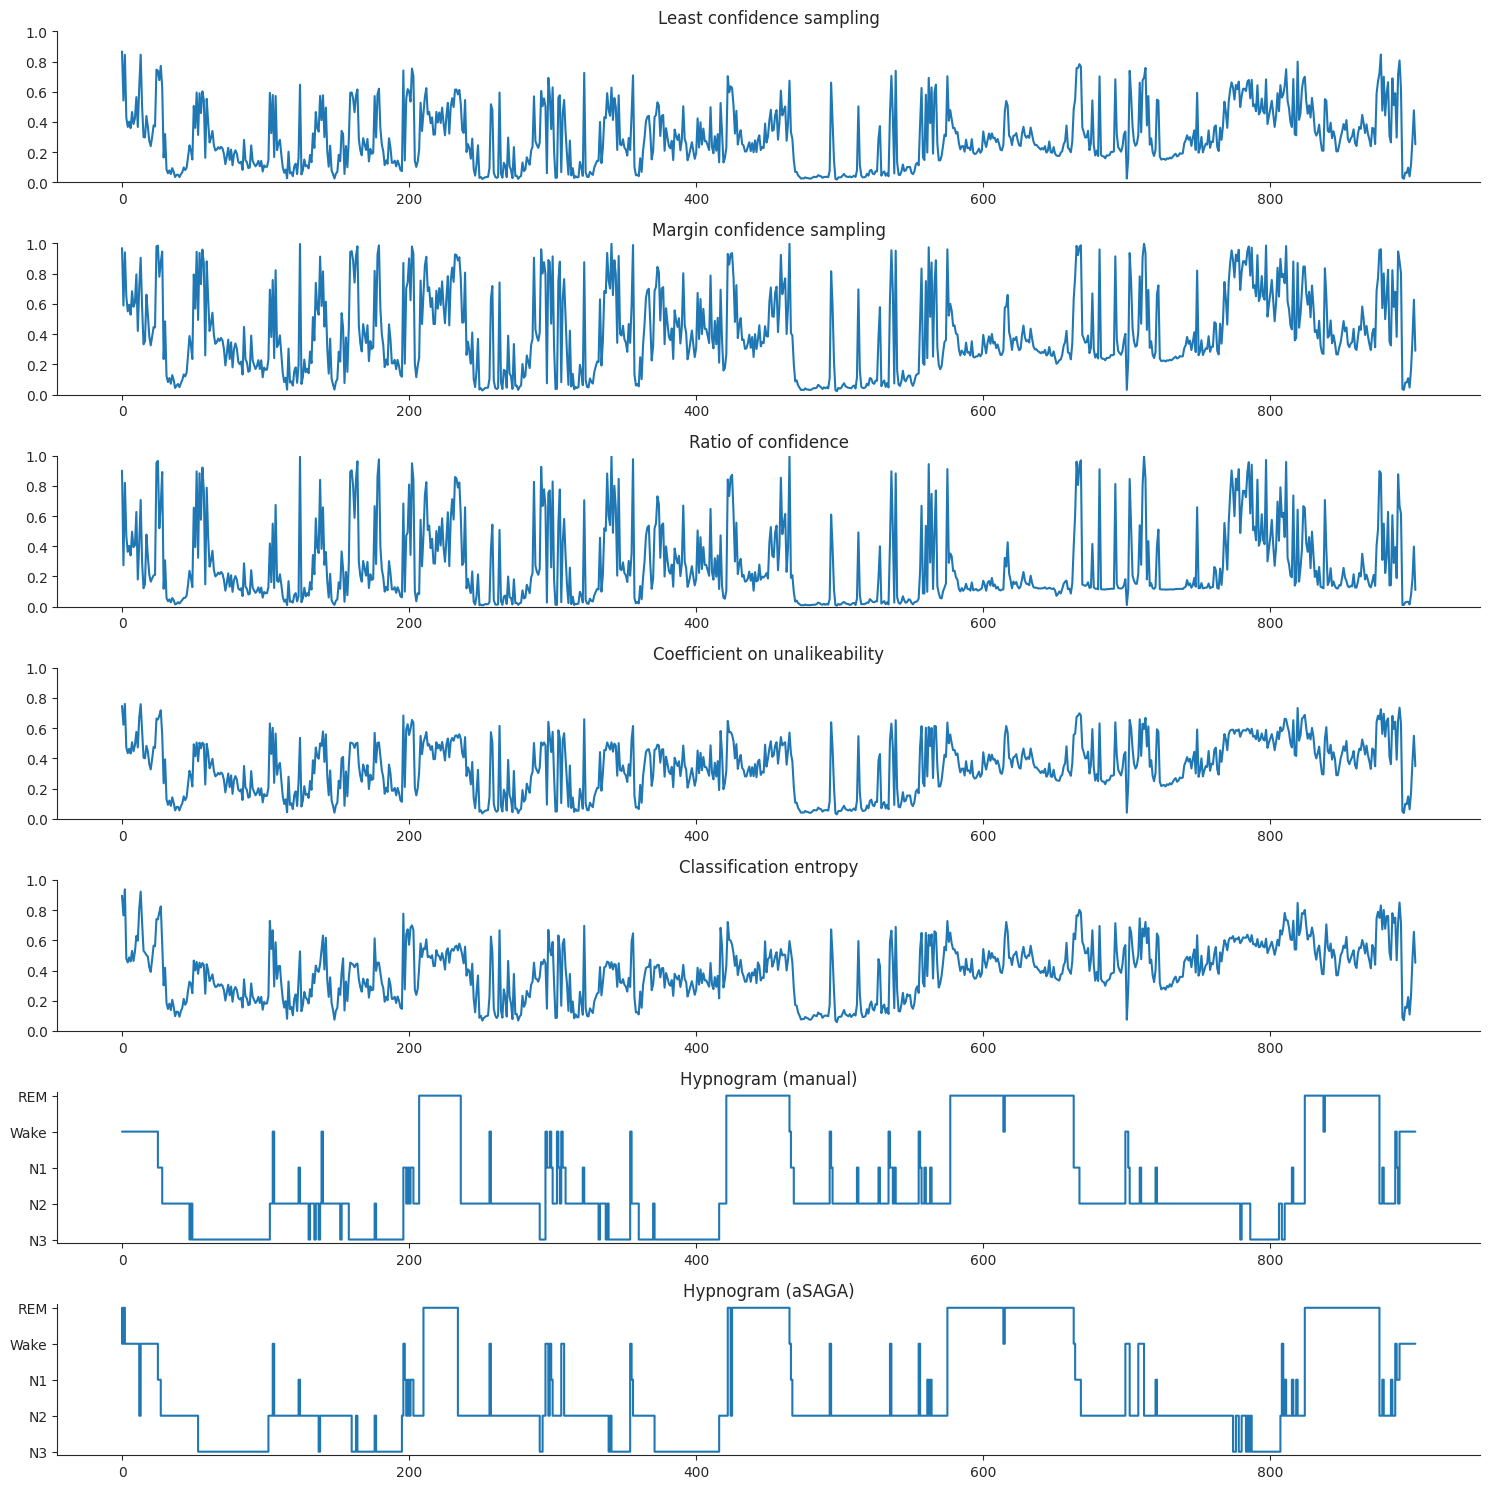

In [5]:
# Example figure for one patient with different uncertainty estimates

fig, ax = plt.subplots(7,1, figsize=(15,15))
sns.despine()
ax[0].plot(u1[0])
ax[0].set_title('Least confidence sampling')
ax[0].set_ylim([0, 1])
ax[1].plot(u2[0])
ax[1].set_title('Margin confidence sampling')
ax[1].set_ylim([0, 1])
ax[2].plot(u3[0])
ax[2].set_title('Ratio of confidence')
ax[2].set_ylim([0, 1])
ax[3].plot(u4[0])
ax[3].set_title('Coefficient on unalikeability')
ax[3].set_ylim([0, 1])
ax[4].plot(u5[0])
ax[4].set_title('Classification entropy')
ax[4].set_ylim([0, 1])
ax[5].step(range(len(hg_tru[0])),remap(np.array(hg_tru[0])))
ax[5].set_title('Hypnogram (manual)')
ax[5].set_yticks(ticks=[0, 1, 2, 3, 4], labels=['N3', 'N2', 'N1', 'Wake', 'REM'])
ax[5].set_ylim([-0.1, 4.1])
ax[6].step(range(len(hg_pre[0])),remap(np.array(hg_pre[0])))
ax[6].set_title('Hypnogram (aSAGA)')
ax[6].set_yticks(ticks=[0, 1, 2, 3, 4], labels=['N3', 'N2', 'N1', 'Wake', 'REM'])
ax[6].set_ylim([-0.1, 4.1])
plt.tight_layout()

## Test how excluding 50% of most uncertain data based on different uncertainty metrics affects the performance metrics

In [6]:
u1_flat = flatten(u1)
u2_flat = flatten(u2)
u3_flat = flatten(u3)
u4_flat = flatten(u4)
u5_flat = flatten(u5)

ind_1 = np.where(u1_flat<np.median(u1_flat))[0]
ind_2 = np.where(u2_flat<np.median(u2_flat))[0]
ind_3 = np.where(u3_flat<np.median(u3_flat))[0]
ind_4 = np.where(u4_flat<np.median(u4_flat))[0]
ind_5 = np.where(u5_flat<np.median(u5_flat))[0]

print('Kappa before excluding any data')
print(cohen_kappa_score(np.array(flatten(hg_tru)),np.array(flatten(hg_pre))))
print('Accuracy before excluding any data')
print(accuracy_score(np.array(flatten(hg_tru)),np.array(flatten(hg_pre))))
print('F1-score before excluding any data')
print(f1_score(np.array(flatten(hg_tru)),np.array(flatten(hg_pre)), average='macro'))

print('Kappa after excluding 50% of data based on')
print('u1: ' + str(cohen_kappa_score(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1])))
print('u2: ' + str(cohen_kappa_score(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2])))
print('u3: ' + str(cohen_kappa_score(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3])))
print('u4: ' + str(cohen_kappa_score(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4])))
print('u5: ' + str(cohen_kappa_score(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5])))

print('Accuracy after excluding 50% of data based on')
print('u1: ' + str(accuracy_score(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1])))
print('u2: ' + str(accuracy_score(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2])))
print('u3: ' + str(accuracy_score(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3])))
print('u4: ' + str(accuracy_score(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4])))
print('u5: ' + str(accuracy_score(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5])))

print('F1-scores after excluding 50% of data based on')
print('u1: ' + str(f1_score(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1], average='weighted')))
print('u2: ' + str(f1_score(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2], average='weighted')))
print('u3: ' + str(f1_score(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3], average='weighted')))
print('u4: ' + str(f1_score(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4], average='weighted')))
print('u5: ' + str(f1_score(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5], average='weighted')))

Kappa before excluding any data
0.739263649316918
Accuracy before excluding any data
0.8224809491300257
F1-score before excluding any data
0.7556287247730674
Kappa after excluding 50% of data based on
u1: 0.9395775794942799
u2: 0.9418483938637618
u3: 0.9393049370231985
u4: 0.9372695850805416
u5: 0.9176713104041245
Accuracy after excluding 50% of data based on
u1: 0.9644623219425787
u2: 0.9658277363643073
u3: 0.9643516126651414
u4: 0.9630600044283711
u5: 0.951214111742564
F1-scores after excluding 50% of data based on
u1: 0.9618233451565771
u2: 0.9629091457516696
u3: 0.9617831551544959
u4: 0.9606086410090181
u5: 0.9498143407311632


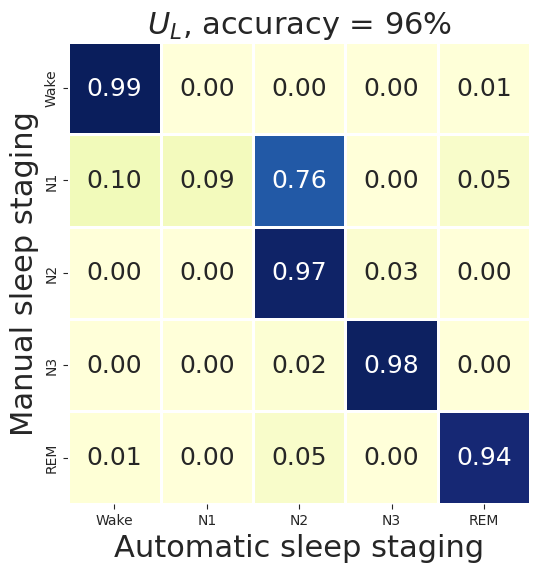

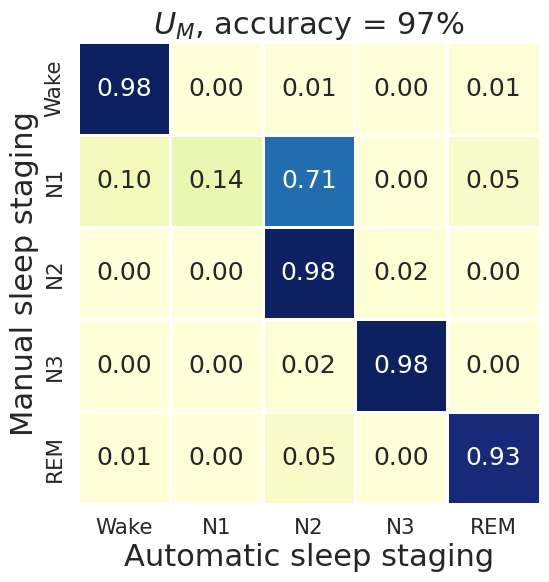

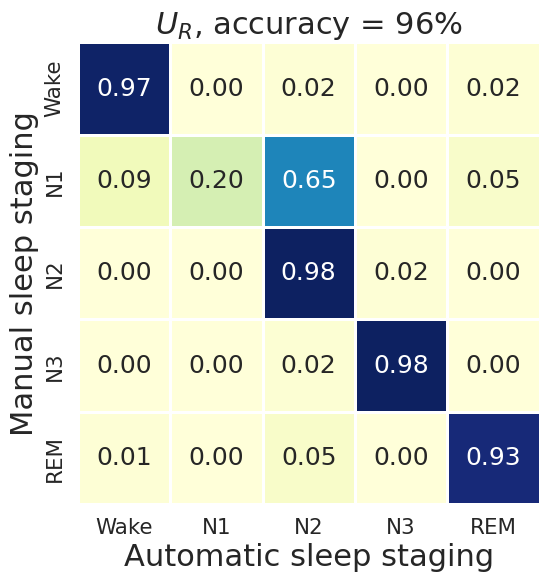

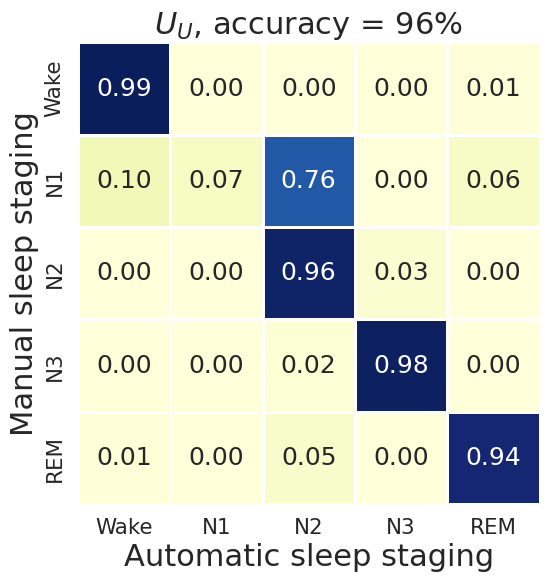

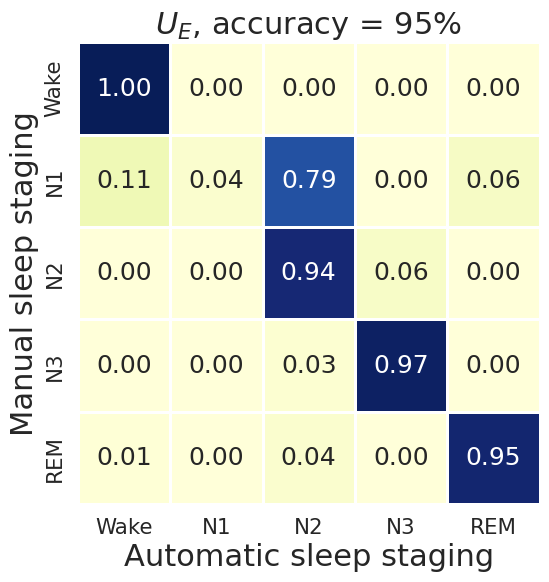

In [7]:
LABELS = ["Wake", "N1", "N2", "N3", "REM"]
fontsize=22

title = '$U_{L}$'
show_confusion_matrix(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1], LABELS, title, fontsize)
title = '$U_{M}$'
show_confusion_matrix(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2], LABELS, title, fontsize)
title = '$U_{R}$'
show_confusion_matrix(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3], LABELS, title, fontsize)
title = '$U_{U}$'
show_confusion_matrix(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4], LABELS, title, fontsize)
title = '$U_{E}$'
show_confusion_matrix(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5], LABELS, title, fontsize)

## Performance metrics and number of confusions as a function of gray area percentage

In [8]:
kap = np.empty((len(np.linspace(0.05, 0.95, 100)), 5))
acc = np.empty((len(np.linspace(0.05, 0.95, 100)), 5))
f1 = np.empty((len(np.linspace(0.05, 0.95, 100)), 5))

for k, limit in enumerate(np.linspace(0.05, 0.95, 100)):
    
    u1_flat = flatten(u1)
    u2_flat = flatten(u2)
    u3_flat = flatten(u3)
    u4_flat = flatten(u4)
    u5_flat = flatten(u5)
    
    ind_1 = np.where(u1_flat<np.quantile(u1_flat,limit))[0]
    ind_2 = np.where(u2_flat<np.quantile(u2_flat,limit))[0]
    ind_3 = np.where(u3_flat<np.quantile(u3_flat,limit))[0]
    ind_4 = np.where(u4_flat<np.quantile(u4_flat,limit))[0]
    ind_5 = np.where(u5_flat<np.quantile(u5_flat,limit))[0]
    
    kap[k, 0] = cohen_kappa_score(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1])
    kap[k, 1] = cohen_kappa_score(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2])
    kap[k, 2] = cohen_kappa_score(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3])
    kap[k, 3] = cohen_kappa_score(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4])
    kap[k, 4] = cohen_kappa_score(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5])
    
    acc[k, 0] = accuracy_score(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1])
    acc[k, 1] = accuracy_score(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2])
    acc[k, 2] = accuracy_score(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3])
    acc[k, 3] = accuracy_score(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4])
    acc[k, 4] = accuracy_score(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5])
    
    f1[k, 0] = f1_score(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1], average='weighted')
    f1[k, 1] = f1_score(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2], average='weighted')
    f1[k, 2] = f1_score(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3], average='weighted')
    f1[k, 3] = f1_score(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4], average='weighted')
    f1[k, 4] = f1_score(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5], average='weighted')

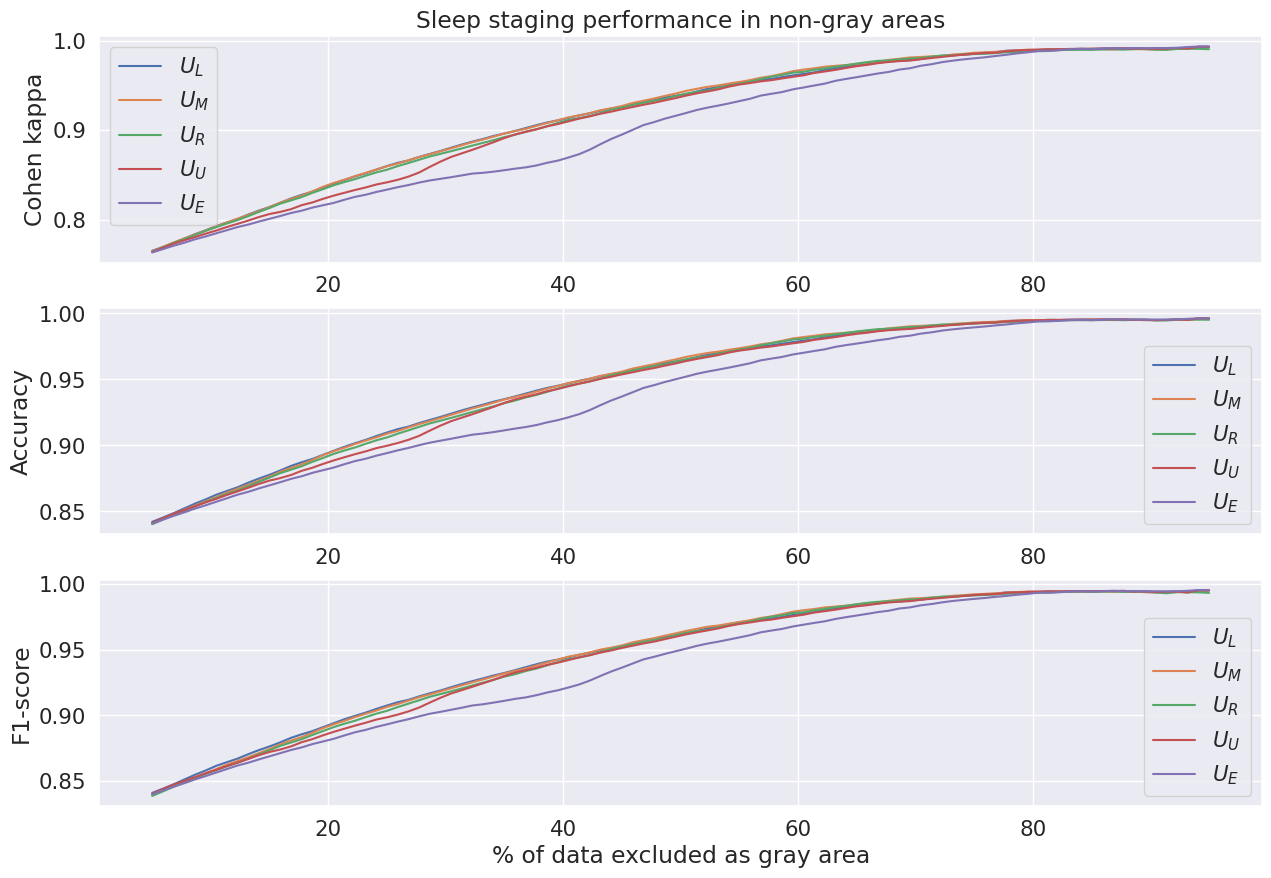

In [9]:
fig, ax = plt.subplots(3,1, figsize=(15,10))

ax[0].plot(100 - np.linspace(0.05, 0.95, 100)*100,kap)
ax[0].set_title('Sleep staging performance in non-gray areas')
ax[0].set_ylabel('Cohen kappa')
ax[0].legend(['$U_{L}$', '$U_{M}$', '$U_{R}$', '$U_{U}$', '$U_{E}$'])
ax[1].plot(100 - np.linspace(0.05, 0.95, 100)*100,acc)
ax[1].set_ylabel('Accuracy')
ax[1].legend(['$U_{L}$', '$U_{M}$', '$U_{R}$', '$U_{U}$', '$U_{E}$'])
ax[2].plot(100 - np.linspace(0.05, 0.95, 100)*100,f1)
ax[2].set_ylabel('F1-score')
ax[2].set_xlabel('% of data excluded as gray area')
ax[2].legend(['$U_{L}$', '$U_{M}$', '$U_{R}$', '$U_{U}$', '$U_{E}$'])

In [10]:
def number_of_confusions(x,y):
    ind = np.where(x==y)[0]
    return (len(x)-len(ind))/len(x)

confusions = np.empty((len(np.linspace(0.01, 0.99, 100)), 5))

for k, limit in enumerate(np.linspace(0.01, 0.99, 100)):
    
    u1_flat = flatten(u1)
    u2_flat = flatten(u2)
    u3_flat = flatten(u3)
    u4_flat = flatten(u4)
    u5_flat = flatten(u5)
    
    ind_1 = np.where(u1_flat<np.quantile(u1_flat,limit))[0]
    ind_2 = np.where(u2_flat<np.quantile(u2_flat,limit))[0]
    ind_3 = np.where(u3_flat<np.quantile(u3_flat,limit))[0]
    ind_4 = np.where(u4_flat<np.quantile(u4_flat,limit))[0]
    ind_5 = np.where(u5_flat<np.quantile(u5_flat,limit))[0]

    
    confusions[k, 0] = number_of_confusions(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1])
    confusions[k, 1] = number_of_confusions(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2])
    confusions[k, 2] = number_of_confusions(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3])
    confusions[k, 3] = number_of_confusions(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4])
    confusions[k, 4] = number_of_confusions(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5])

Text(0.5, 0, '% of data excluded as gray area')

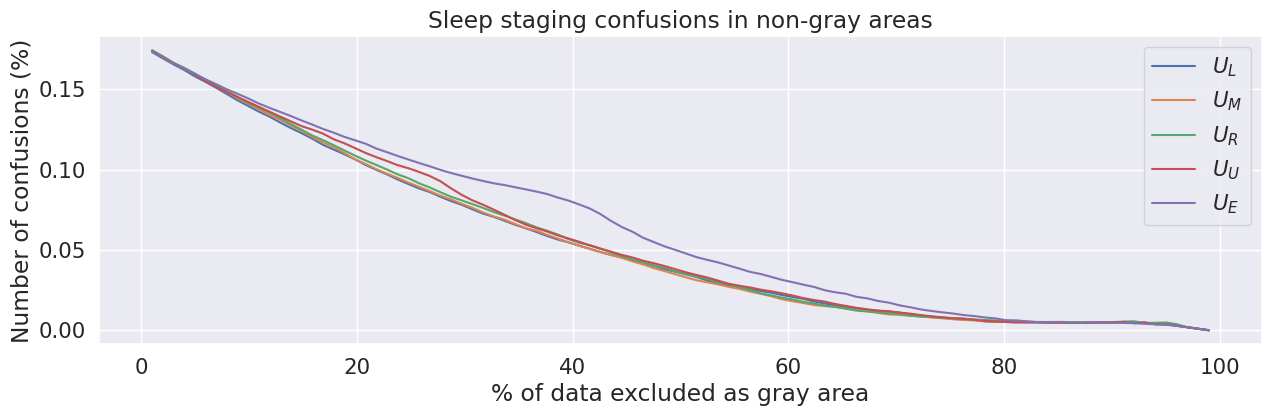

In [11]:
fig, ax = plt.subplots(1,1,figsize=(15,4))

ax.plot(100 - np.linspace(0.01, 0.99, 100)*100,confusions)
ax.set_title('Sleep staging confusions in non-gray areas')
ax.set_ylabel('Number of confusions (%)')
ax.legend(['$U_{L}$', '$U_{M}$', '$U_{R}$', '$U_{U}$', '$U_{E}$'])
ax.set_xlabel('% of data excluded as gray area')

In [12]:
def number_of_confusions(x,y,n):
    ind = np.where(x==y)[0]
    return (len(x)-len(ind))/n

confusions = np.empty((len(np.linspace(0.01, 0.99, 100)), 6))
conf_n = len(np.where(np.array(flatten(hg_tru))!=np.array(flatten(hg_pre)))[0])
rng = np.random.default_rng(seed=42)

for k, limit in enumerate(np.linspace(0.01, 0.99, 100)):
    
    u1_flat = flatten(u1)
    u2_flat = flatten(u2)
    u3_flat = flatten(u3)
    u4_flat = flatten(u4)
    u5_flat = flatten(u5)
    
    ind_1 = np.where(u1_flat>np.quantile(u1_flat,limit))[0]
    ind_2 = np.where(u2_flat>np.quantile(u2_flat,limit))[0]
    ind_3 = np.where(u3_flat>np.quantile(u3_flat,limit))[0]
    ind_4 = np.where(u4_flat>np.quantile(u4_flat,limit))[0]
    ind_5 = np.where(u5_flat>np.quantile(u5_flat,limit))[0]
    rand = rng.integers(low=0, high=len(u1_flat), size=len(ind_1))
    
    confusions[k, 0] = number_of_confusions(np.array(flatten(hg_tru))[ind_1],np.array(flatten(hg_pre))[ind_1], conf_n)
    confusions[k, 1] = number_of_confusions(np.array(flatten(hg_tru))[ind_2],np.array(flatten(hg_pre))[ind_2], conf_n)
    confusions[k, 2] = number_of_confusions(np.array(flatten(hg_tru))[ind_3],np.array(flatten(hg_pre))[ind_3], conf_n)
    confusions[k, 3] = number_of_confusions(np.array(flatten(hg_tru))[ind_4],np.array(flatten(hg_pre))[ind_4], conf_n)
    confusions[k, 4] = number_of_confusions(np.array(flatten(hg_tru))[ind_5],np.array(flatten(hg_pre))[ind_5], conf_n)
    confusions[k, 5] = number_of_confusions(np.array(flatten(hg_tru))[rand],np.array(flatten(hg_pre))[rand], conf_n)

Text(0.5, 0, '% of data considered as gray area')

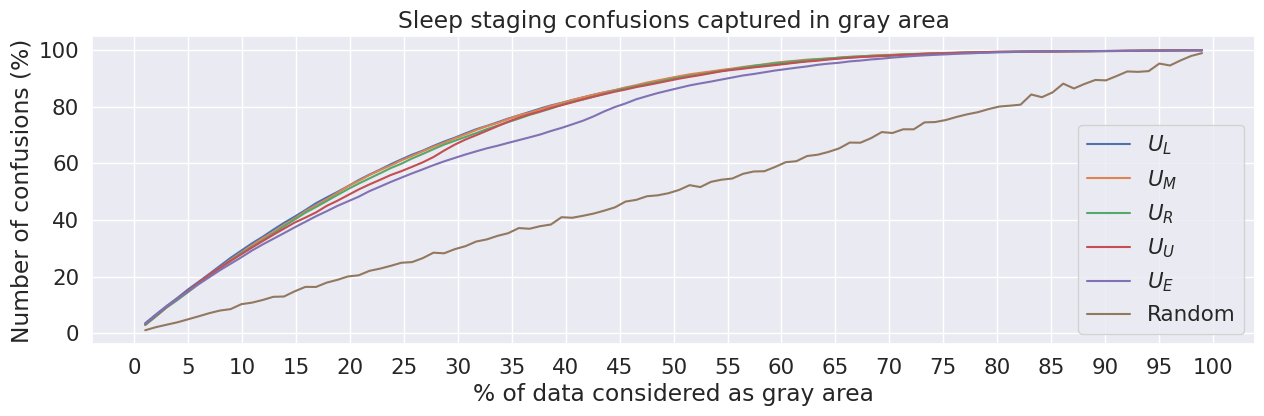

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,4))

ax.plot(100 - np.linspace(0.01, 0.99, 100)*100,confusions*100)
ax.set_title('Sleep staging confusions captured in gray area')
ax.set_ylabel('Number of confusions (%)')
ax.set_xticks(range(0,105,5))
ax.legend(['$U_{L}$', '$U_{M}$', '$U_{R}$', '$U_{U}$', '$U_{E}$', 'Random'])
ax.set_xlabel('% of data considered as gray area')